## Обучение на основе модели: алгоритм Dyna-Q

В данной тетрадке мы реализуем табличный алгоритм Dyna-Q. Для этого мы воспользуемся кодом для табличного Q-обучения.

<img src="https://raw.githubusercontent.com/Tviskaron/mipt/master/2019/RL/10/dyna.png">

In [1]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 30.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 8.5 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from functools import partial
from IPython.display import clear_output

%matplotlib inline

In [3]:
def show_progress(avg_returns):
    """
    Удобная функция, которая отображает прогресс обучения.
    """
    clear_output(True)
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 1, 1)
    plt.plot(*zip(*avg_returns), label='Mean return')
    plt.legend(loc=4)
    plt.grid()
    plt.show()

def compare_logs(logs):
    """Функция сравнения кривых обучения"""
    plt.figure(figsize=[12, 6])
    for log, method_name in logs:
        plt.plot(*zip(*log), label=f'{method_name}')
        plt.legend()
    plt.grid()
    plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


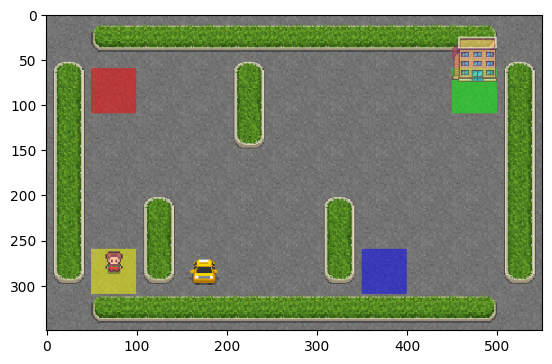

In [4]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset(seed=13)
plt.imshow(env.render())

### Задание 1: Реализуйте методы класса Model, которые позволят вам сохранять и получать необходимые кортежи данных.

In [110]:
class Model:
    def __init__(self, n_states, n_actions, seed):
        ####### Здесь ваш код ########
        self.n_states = n_states
        self.n_actions = n_actions
        self._transitions = np.zeros((n_states, n_actions), dtype=np.int32)
        self._rewards = np.zeros_like(self._transitions, dtype=np.float32)

        self.mask_state_action =  np.zeros_like(self._transitions, dtype=np.float32)
        self.mask_state = np.zeros(n_states, dtype=np.int32)

        ##############################
        self._rng = np.random.default_rng(seed)

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        ####### Здесь ваш код ########
        self._rewards[s][a] = r
        self._transitions[s][a] = next_s

        self.mask_state[s] += 1
        self.mask_state_action[s][a] += 1 
        ##############################
        return r

    def sample(self) -> tuple[int, int, float, int]:
        """
        returns s, a, r, next_s
        """
        ####### Здесь ваш код ########
        s = self._rng.choice(np.where(self.mask_state !=0)[0])
        actions = self.mask_state_action[s]
        a = self._rng.choice(np.where(actions !=0)[0])
        r = self._rewards[s][a]
        next_s = self._transitions[s][a]
        return s, a, r, next_s 
        ##############################

In [111]:
class DynaQAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, f_model, seed):
        self.Q = np.zeros((n_states, n_actions))
        self.model = f_model(n_states, n_actions, seed=seed)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)
        
    def act(self, s):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if self._rng.random() < self.eps:
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, update_model: bool):
        # Обновите модель, если нужно, реализуйте шаг Q-обучения
        ####### Здесь ваш код ########
        self.Q[s, a] += self.lr * (r + self.gamma * np.max(self.Q[s_n]) - self.Q[s, a])
        if update_model:
            _ = self.model.add(s, a, r, s_n)
        ##############################
        
    def dream(self, max_steps, **_):
        for _ in range(max_steps):
            # Добавьте шаг обучения с использованием модели
            ####### Здесь ваш код ########
            s, a, r, s_n = self.model.sample()
            self.update(s, a, r, s_n, False)
            ##############################

In [98]:
def train(env, agent, n_episodes, on_model_updates, seed, show_progress_schedule=50):
    avg_returns, returns_batch = [], []
    rng = np.random.default_rng(seed)

    for i in range(1, n_episodes):
        state, _ = env.reset(seed=int(rng.integers(10000000)))
        reward, episode_return = 0, 0
        done = False
        while not done:
            action = agent.act(state)

            # выполняем действие в среде
            next_state, reward, terminated, truncated, info = env.step(action)
            agent.update(state, action, reward, next_state, update_model=True)
            agent.dream(on_model_updates, state=state)

            state = next_state
            episode_return += reward
            done = terminated or truncated

        returns_batch.append(episode_return)

        if i % show_progress_schedule == 0:
            avg_returns.append((i, np.mean(returns_batch)))
            returns_batch = []
            
            show_progress(avg_returns)
            print(
                f"Episode: {i}, Return: {episode_return}, "
                f"AvgReturn[{show_progress_schedule}]: {avg_returns[-1][1]:.0f}"
            )

    return avg_returns

### Обычный Q-learning

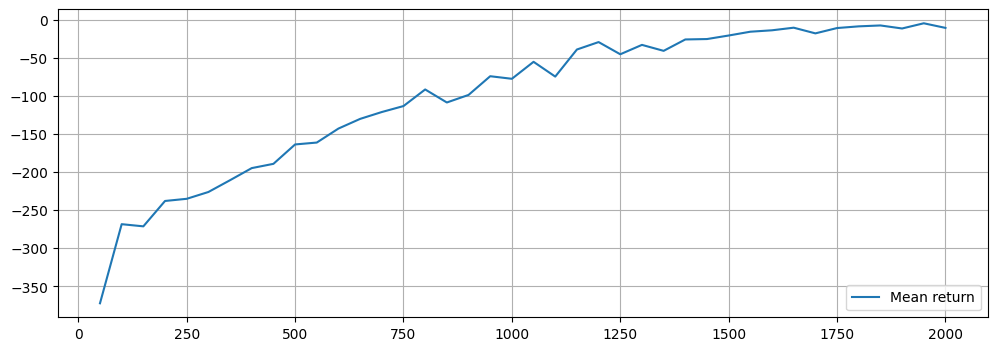

Episode: 2000, Return: -14, AvgReturn[50]: -10


In [56]:
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)

log_q = train(env, agent, n_episodes=2001, on_model_updates=0, seed=seed, show_progress_schedule=50)

### DynaQ

1. Сравните скорость обучения алгоритма Dyna-Q с параметром on_model_updates равным 10 и алгоритма Q-обучение.
2. Сравните скорость обучения при различных on_model_updates. В каком случае получились лучшие результаты?

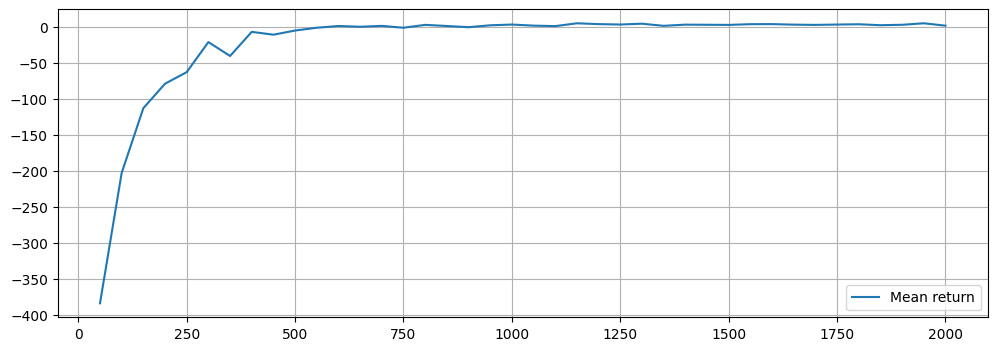

Episode: 2000, Return: -7, AvgReturn[50]: 1


In [99]:
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)
log_dyna_q = train(env, agent, n_episodes=2001, on_model_updates=10, seed=seed)

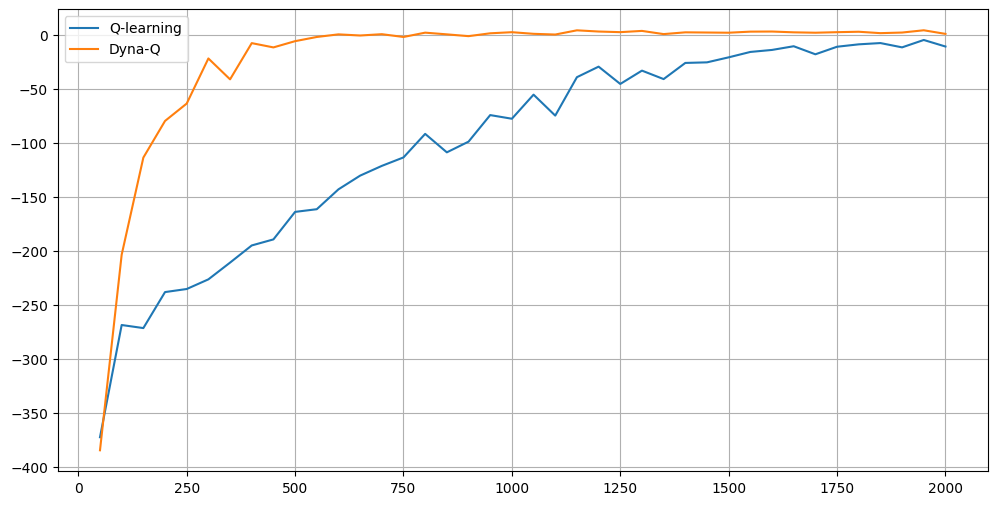

In [100]:
compare_logs([
    (log_q, 'Q-learning'),
    (log_dyna_q, 'Dyna-Q')
])

## Dyna-Q with imperfect model

Давайте теперь представим, что мы не знаем ничего о среде (например, что она детерминированная), и будем учить переходы $\alpha$-обучением, то есть с некоторым learning rate'ом.

In [131]:
class ImperfectModel:
    def __init__(self, n_states, n_actions, lr: float, seed: int):
        ####### Здесь ваш код ########
        self._rewards = np.zeros(n_states, dtype = np.float32)
        self._transitions = np.zeros((n_states, n_actions), dtype = np.int32)
        self.mask_state_action = np.zeros_like(self._transitions, dtype=np.float32)
        self.mask_state = np.zeros_like(self._rewards, dtype=np.int32)
        self.lr = lr
        ##############################
        self._rng = np.random.default_rng(seed)

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        ####### Здесь ваш код ########
        self._rewards[next_s] = r
        self._transitions[s, a] = next_s
        self.mask_state[s] += 1
        self.mask_state_action[s, a] = self.mask_state_action[s, a] * (1  - self.lr) + self.lr

        ##############################
        return r

    def sample_state(self):
        ####### Здесь ваш код ########
        s = self._rng.choice(np.where(self.mask_state !=0)[0])
        ##############################
        return s

    def sample_action(self, s):
        ####### Здесь ваш код ########
        a = self._rng.choice(np.where(self.mask_state_action[s] !=0)[0])
        ##############################
        return a

    def predict_transition(self, s, a):
        ####### Здесь ваш код ########
        anomaly_prob = 1 - self.mask_state_action[s, a]
        if self._rng.random() < anomaly_prob:
            next_s = self._rng.choice(np.where(self.mask_state !=0)[0])
        else:
            next_s = self._transitions[s, a]
        ##############################
        return self._rewards[next_s], next_s

    def sample(self) -> tuple[int, int, float, int]:
        """
        returns s, a, r, next_s
        """
        ####### Здесь ваш код ########
        s = self.sample_state()
        a = self.sample_action(s)
        r, next_s = self.predict_transition(s, a)
        return s, a, r, next_s 
        ##############################

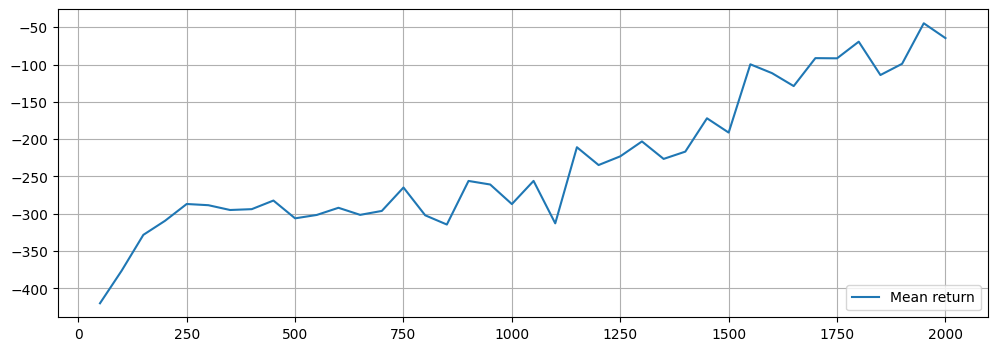

Episode: 2000, Return: -272, AvgReturn[50]: -65


In [132]:
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=partial(ImperfectModel, lr=0.1)
)

log_dyna_q_imp = train(env, agent, n_episodes=2001, on_model_updates=10, seed=seed)

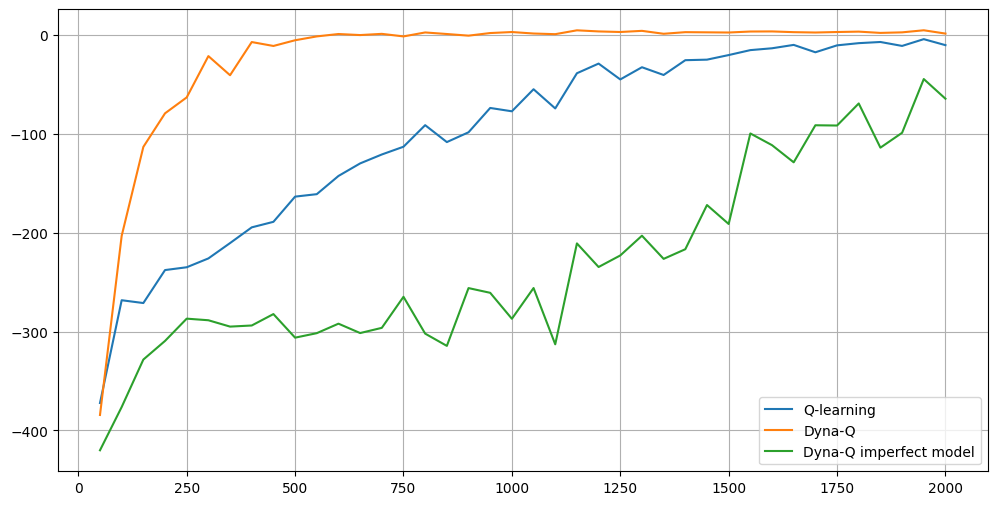

In [133]:
compare_logs([
    (log_q, 'Q-learning'),
    (log_dyna_q, 'Dyna-Q'),
    (log_dyna_q_imp, 'Dyna-Q imperfect model'),
])

## Dyna-Q with imperfect model and prediction error based intrinsic motivation

Сигнал ошибки модели является хорошим сигналом мотивации к исследованию, "отправляя" агента в недоисследованные зоны пространства состояний. Как следствие два плюса: а) более быстрое и целенаправленное обучение модели среды (которая дает бонус к скорости обучению через обучение в воображении) и б) более целенаправленное исследование самой среды, которое поможет агенту быстрее найти состояния с высоким внешним вознаграждением.

Давайте посмотрим, так ли это. Реализуйте аналогичную предыдущему пункту "неидеальную" внутреннюю модель среды агента, но теперь также добавьте в нее внутреннюю мотивацию. Для этого можно, например, добавлять ошибку предсказания $1 - P[s_{t+1} |s_t,a_t]$ к полученному внешнему вознаграждению $r_{t+1}$ при обучении функции вознаграждения.

In [134]:
class IntrinsicMotivationModel(ImperfectModel):
    def __init__(self, n_states, n_actions, lr: float, add_intrinsic: bool, seed: int):
        super().__init__(n_states, n_actions, lr, seed)
        self.add_intrinsic = add_intrinsic

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        if self.add_intrinsic:
            # calculate intrinsic motivation signal
            ####### Здесь ваш код ########
            r_im = 1. - self.mask_state_action[s, a]
            ##############################
            r += 0.25 * r_im
        return super().add(s, a, r, next_s)

Сначала возьмем задачу попроще и проверим, что все работает

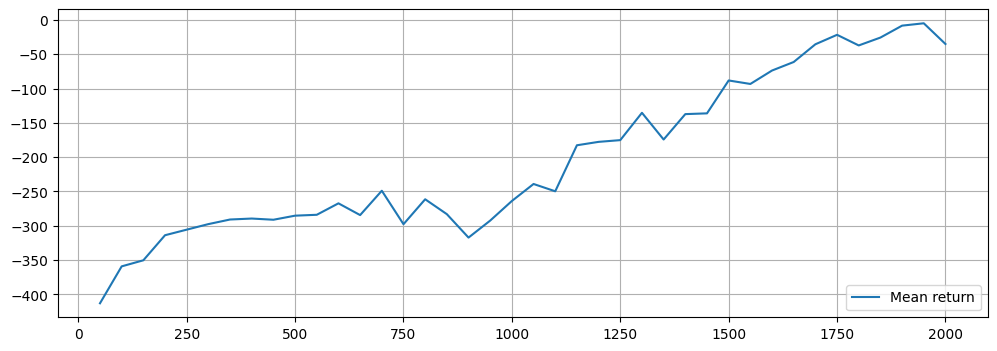

Episode: 2000, Return: -30, AvgReturn[50]: -35


In [135]:
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.1, add_intrinsic=True)
)

log_dyna_q_imp_im = train(env, agent, n_episodes=2001, on_model_updates=10, seed=seed)

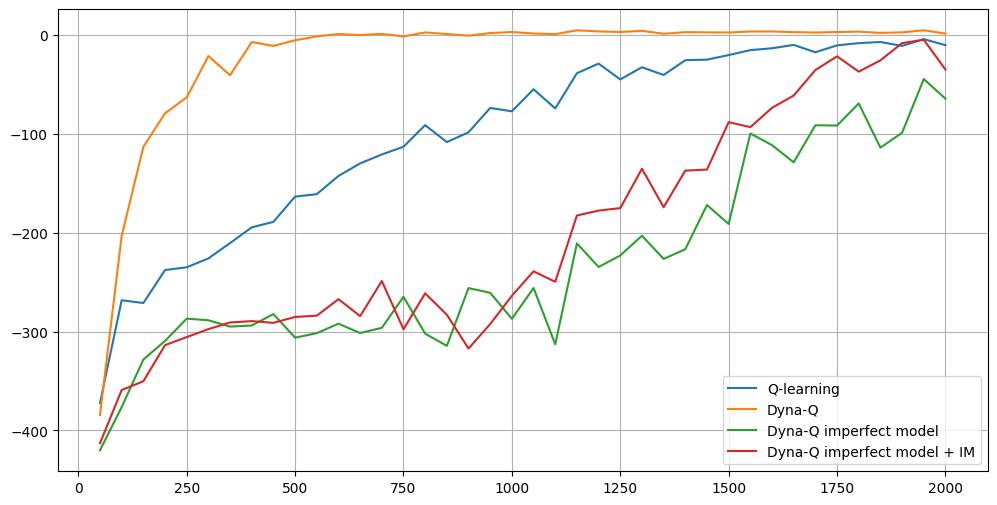

In [136]:
compare_logs([
    (log_q, 'Q-learning'),
    (log_dyna_q, 'Dyna-Q'),
    (log_dyna_q_imp, 'Dyna-Q imperfect model'),
    (log_dyna_q_imp_im, 'Dyna-Q imperfect model + IM')
])

## With imaginary trajectories
До этого процесс обучения в воображении происходил беспорядочно — агент случайно сэмплировал состояние, которое ему знакомо, воображал переход и обучался на одном переходе. Теперь давайте попробуем воспроизвести процесс обучения в воображении, похожий на сновидение — чтобы агент воображал целую траекторию, начинающуюся с текущего состояния (то есть додумывал/планировал возможное продолжение событий, начиная с текущего момента).

In [149]:
class DynaQDreamerAgent(DynaQAgent):
    def dream(self, max_steps, state):
        # current state is the starting state for a dreaming rollout
        s = state
        for _ in range(max_steps):
            # add dreaming step
            ####### Здесь ваш код ########
            a = self.act(s)
            r, next_s = self.model.predict_transition(s, a)
            self.update(s, a, r, next_s, False)
            ##############################
            s = next_s

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


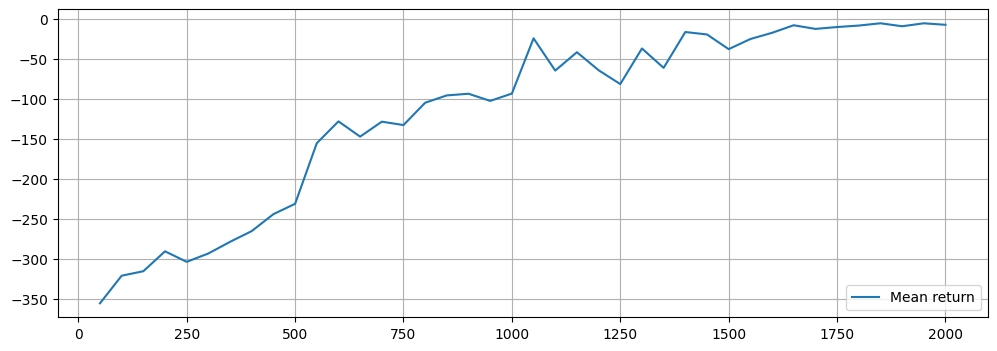

Episode: 2000, Return: -27, AvgReturn[50]: -8


In [140]:
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQDreamerAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.1, add_intrinsic=False)
)

log_dyna_q_imp_im_dreamer = train(env, agent, n_episodes=2001, on_model_updates=10, seed=seed)

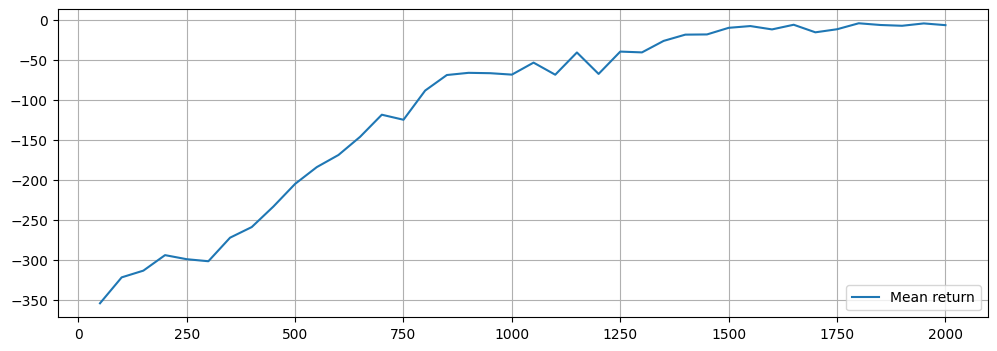

Episode: 2000, Return: -13, AvgReturn[50]: -7


In [141]:
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQDreamerAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.1, add_intrinsic=True)
)

log_dyna_q_imp_im_dreamer = train(env, agent, n_episodes=2001, on_model_updates=10, seed=seed)

## Let's wrap up by comparing them side-by-side
Теперь сэмулируем задачу посложнее и сравним результаты (обратите внимание на параметры eps и lr)

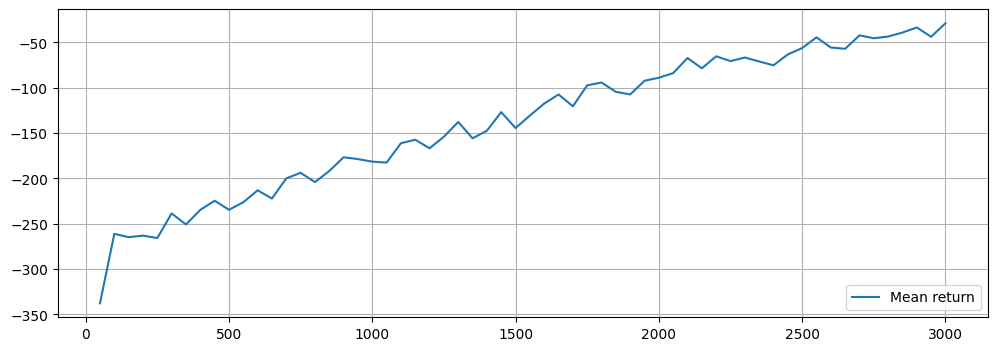

Episode: 3000, Return: -92, AvgReturn[50]: -29


In [142]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=Model
)

log_q = train(env, agent, n_episodes=3001, on_model_updates=0, seed=seed, show_progress_schedule=50)

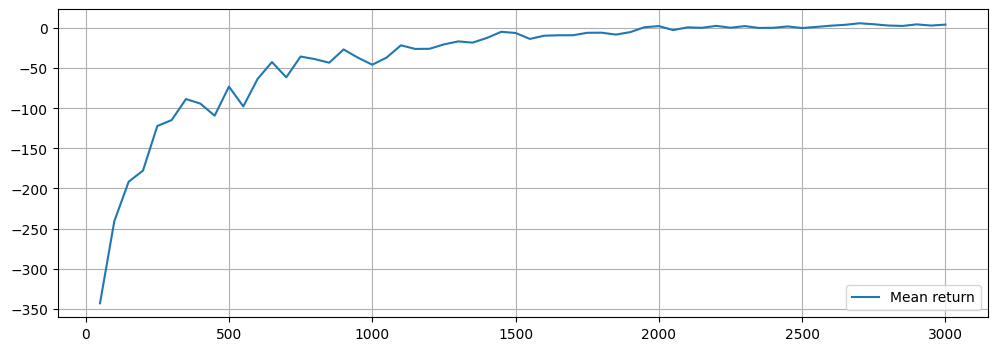

Episode: 3000, Return: -69, AvgReturn[50]: 4


In [143]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=Model
)
log_dyna_q = train(env, agent, n_episodes=3001, on_model_updates=4, seed=seed)

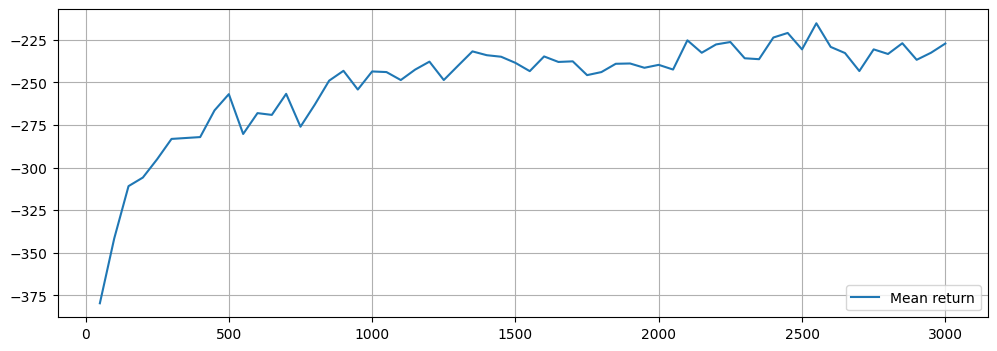

Episode: 3000, Return: -200, AvgReturn[50]: -227


In [144]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=partial(ImperfectModel, lr=0.02)
)

log_dyna_q_imp = train(env, agent, n_episodes=3001, on_model_updates=4, seed=seed)

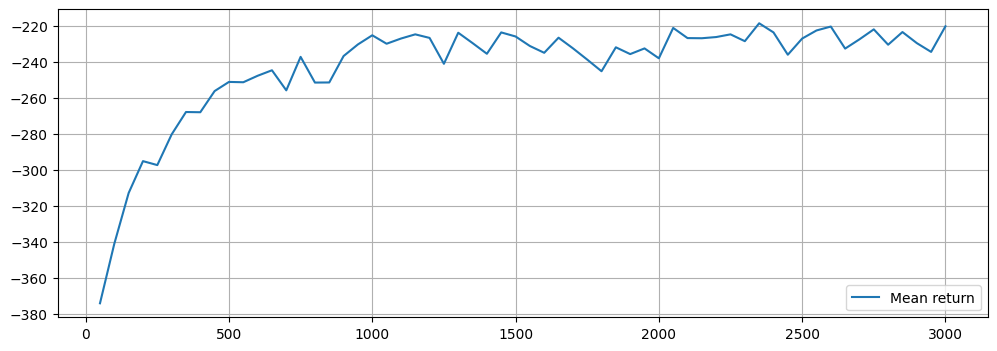

Episode: 3000, Return: -218, AvgReturn[50]: -220


In [145]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.02, add_intrinsic=True)
)

log_dyna_q_imp_im = train(env, agent, n_episodes=3001, on_model_updates=4, seed=seed)

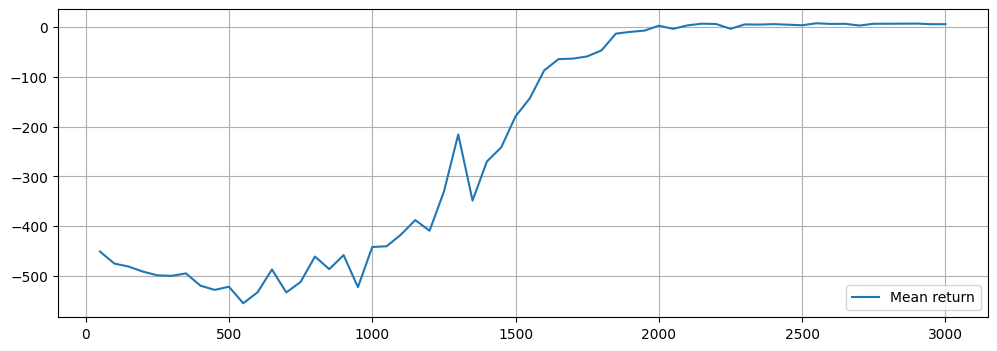

Episode: 3000, Return: 4, AvgReturn[50]: 6


In [151]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQDreamerAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.02, add_intrinsic=False)
)

log_dyna_q_imp_dreamer = train(env, agent, n_episodes=3001, on_model_updates=4, seed=seed)

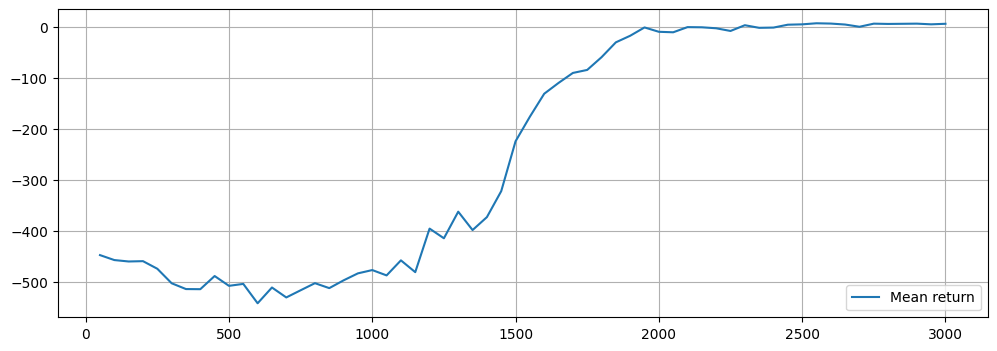

Episode: 3000, Return: 4, AvgReturn[50]: 7


In [152]:
env = gym.make("Taxi-v3")
seed = 42
agent = DynaQDreamerAgent(
    env.observation_space.n, env.action_space.n, lr=0.02, gamma=0.975, eps=0.02, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.02, add_intrinsic=True)
)

log_dyna_q_imp_im_dreamer = train(env, agent, n_episodes=3001, on_model_updates=4, seed=seed)

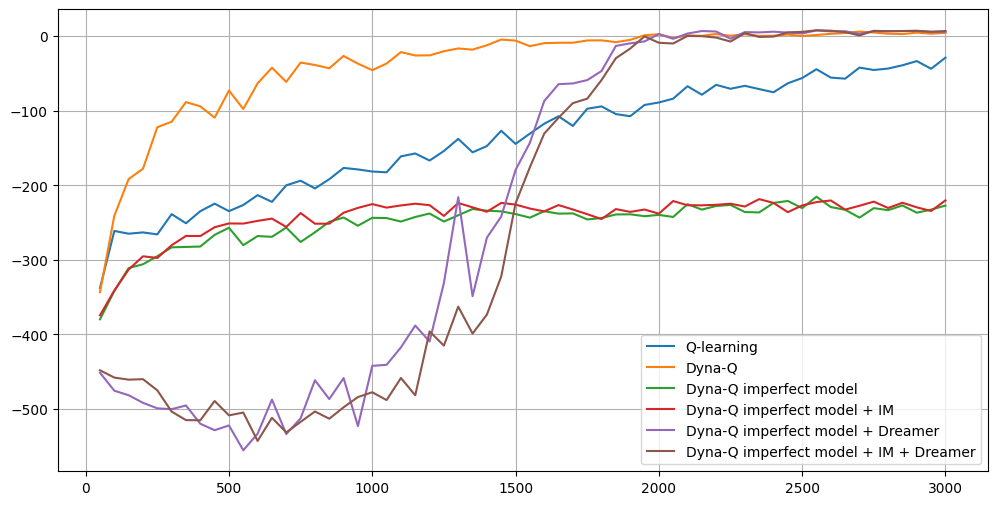

In [153]:
compare_logs([
    (log_q, 'Q-learning'),
    (log_dyna_q, 'Dyna-Q'),
    (log_dyna_q_imp, 'Dyna-Q imperfect model'),
    (log_dyna_q_imp_im, 'Dyna-Q imperfect model + IM'),
    (log_dyna_q_imp_dreamer, 'Dyna-Q imperfect model + Dreamer'),
    (log_dyna_q_imp_im_dreamer, 'Dyna-Q imperfect model + IM + Dreamer'),
])